In [45]:
#import libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [46]:
LR=1e-4   #0.00001
EPOCHS=20
BS=32
Data='/content/drive/MyDrive/dataset'
Categories=['with mask','without mask']
data=[]
labels=[]

print("[Info ] loading images ..")

for category in Categories:
  path=os.path.join(Data,category)
  for img in os.listdir(path):
    img_path=os.path.join(path,img)
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)

    data.append(image)
    labels.append(category)

[Info ] loading images ..


In [47]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)
data=np.array(data,dtype="float32")
labels=np.array(labels)

In [48]:
x_train,x_test,y_train,y_test=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=42)

In [49]:
aug=ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")


In [50]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# Load MobileNetV2 without the top (fully connected) layers
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Build the head of the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Create the final model
model = Model(inputs=baseModel.input, outputs=headModel)


In [52]:
import tensorflow as tf
for layer in baseModel.layers:
  layer.trainble=False
print("[Info] compiling model ...")
lr_schedule =tf.keras.optimizers.schedules.ExponentialDecay(
    LR, decay_steps=10000, decay_rate=0.9
)
opt = Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])
print("[Info] training head ...")
H=model.fit(
    aug.flow(x_train,y_train,batch_size=BS),
    steps_per_epoch=len(x_train) // BS,
    validation_data=(x_test,y_test),
    validation_steps=len(x_test)//BS,
    epochs=EPOCHS
)

[Info] compiling model ...
[Info] training head ...
Epoch 1/20
38/38 [==============================] - 241s 6s/step - loss: 0.2984 - accuracy: 0.8912 - val_loss: 0.0387 - val_accuracy: 0.9935
Epoch 2/20
38/38 [==============================] - 219s 6s/step - loss: 0.0319 - accuracy: 0.9950 - val_loss: 0.0175 - val_accuracy: 0.9967
Epoch 3/20
38/38 [==============================] - 220s 6s/step - loss: 0.0163 - accuracy: 0.9942 - val_loss: 0.0165 - val_accuracy: 0.9935
Epoch 4/20
38/38 [==============================] - 221s 6s/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 0.9967
Epoch 5/20
38/38 [==============================] - 216s 6s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 0.9967
Epoch 6/20
38/38 [==============================] - 214s 6s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9967
Epoch 7/20
38/38 [==============================] - 209s 6s/step - loss: 0.0038 - accuracy: 0.9983 - v

In [53]:
for l in model.layers:
  print(l.name,l.trainable)

input_10 True
Conv1 True
bn_Conv1 True
Conv1_relu True
expanded_conv_depthwise True
expanded_conv_depthwise_BN True
expanded_conv_depthwise_relu True
expanded_conv_project True
expanded_conv_project_BN True
block_1_expand True
block_1_expand_BN True
block_1_expand_relu True
block_1_pad True
block_1_depthwise True
block_1_depthwise_BN True
block_1_depthwise_relu True
block_1_project True
block_1_project_BN True
block_2_expand True
block_2_expand_BN True
block_2_expand_relu True
block_2_depthwise True
block_2_depthwise_BN True
block_2_depthwise_relu True
block_2_project True
block_2_project_BN True
block_2_add True
block_3_expand True
block_3_expand_BN True
block_3_expand_relu True
block_3_pad True
block_3_depthwise True
block_3_depthwise_BN True
block_3_depthwise_relu True
block_3_project True
block_3_project_BN True
block_4_expand True
block_4_expand_BN True
block_4_expand_relu True
block_4_depthwise True
block_4_depthwise_BN True
block_4_depthwise_relu True
block_4_project True
block_

In [54]:
print("[INFO] evaluating network...")
pred=model.predict(x_test,batch_size=BS)
pred=np.argmax(pred,axis=1)

[INFO] evaluating network...
10/10 [==============================] - 10s 828ms/step


In [55]:
print(classification_report(y_test.argmax(axis=1),pred,target_names=lb.classes_))

              precision    recall  f1-score   support

   with mask       1.00      1.00      1.00       158
without mask       1.00      1.00      1.00       149

    accuracy                           1.00       307
   macro avg       1.00      1.00      1.00       307
weighted avg       1.00      1.00      1.00       307



In [56]:
print("[INFO] saving mask_detector ...")
model.save("mask_detector.model",save_format="h5")

[INFO] saving mask_detector ...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


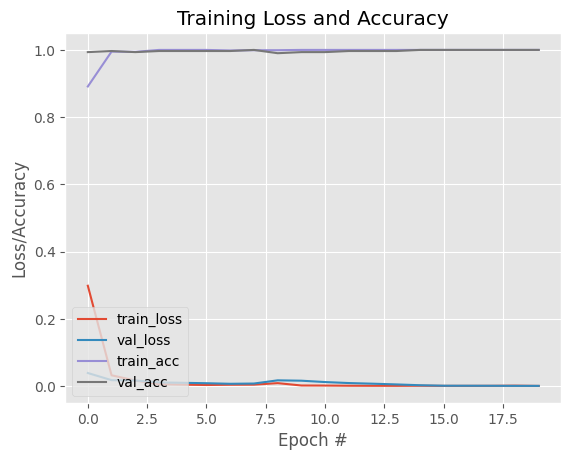

In [58]:
N=EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,N),H.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,N),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,N),H.history["val_accuracy"],label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")